## TODO

* update slides
* what can we conclude from these visualizations

To analyize:
* voor de duration analysis moeten we alle participanten includeren
* voor de arousal valance analyis moeten we de participanten excluderen die dezelfde pictures meerde malen hebben beschreven.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("talk")

import sys

sys.path.append("..")
from GSSP_utils.path_conf import loc_data_dir, speech_web_app_image_dir
from GSSP_utils.conf import color_palette


pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
df_session = pd.read_parquet(loc_data_dir.joinpath("df_session_tot_cleaned.parquet"))
print(df_session.shape)

# Sanity check: we should have no duplicate pic_names for the same user (ID)
out = df_session[df_session.DB != "Marloes"].groupby(["ID", "pic_name"]).size()
display(out[out > 1])  # should be an empty Series
del out


(3257, 22)


Series([], dtype: int64)

In [3]:
# All wav durations below 5 seconds are actually empty files
df_session[(df_session.wav_duration_s < 5)].wav_duration_s

67      0.0
201     0.0
212     0.0
214     0.0
493     0.0
747     0.0
748     0.0
828     0.0
852     0.0
1249    0.0
1268    0.0
1289    0.0
1696    0.0
1713    0.0
1827    0.0
1832    0.0
1839    0.0
1851    0.0
1855    0.0
1873    0.0
1886    0.0
2228    0.0
2509    0.0
3020    0.0
Name: wav_duration_s, dtype: float64

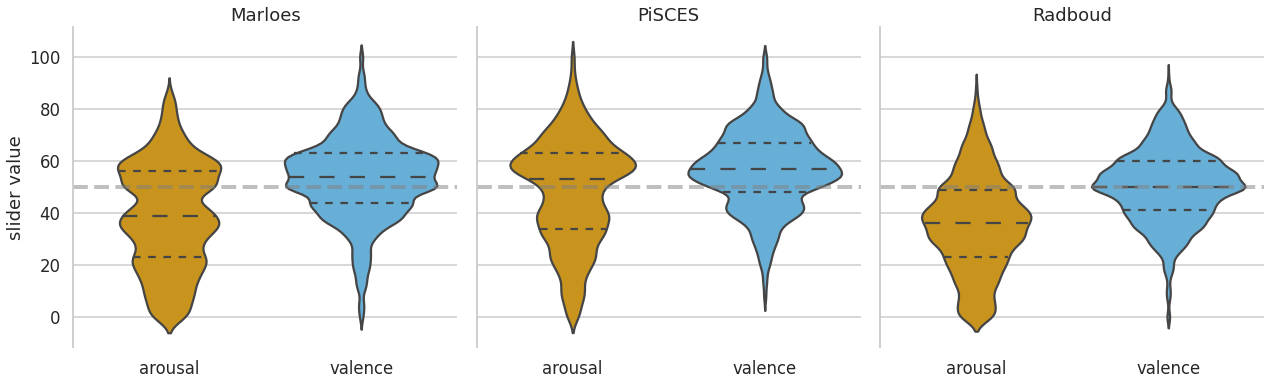

In [4]:
# group level plot of the 
g = sns.catplot(
    data=df_session.melt(
        id_vars=set(df_session.columns).difference({"arousal", "valence"}),
        value_vars=["arousal", "valence"],
        var_name="slider_type",
        value_name="slider value",
    ),
    sharex=True,
    sharey=True,
    legend=True,
    kind="violin",
    x="slider_type",
    y="slider value",
    col="DB",
    palette=color_palette,
    bw=0.15,
    inner="quartile",
    col_wrap=3,
    height=6,
)

for ax in g.axes.flat:
    ax.axhline(50, ls="--", lw=4, alpha=0.5, color="grey")
    ax.spines.bottom.set_visible(False)
    ax.set_xlabel("")
    ax.set_title(ax.get_title().split("=")[1].strip())

plt.show()

## Statistics

In [5]:
from scipy.stats import kstest, mannwhitneyu


In [6]:
db_pic_name_var_score_list = []
for db in ["PiSCES", "Radboud"]:
    for pic_name in df_session[df_session.DB == db].pic_name.unique():
        for variable in ["arousal", "valence"]:
            test = mannwhitneyu(
                df_session[(df_session.DB == db) & (df_session.pic_name == pic_name)][
                    variable
                ],
                df_session[(df_session.DB == db) & (df_session.pic_name != pic_name)][
                    variable
                ],
                alternative="two-sided",
                nan_policy="omit",
            )
            db_pic_name_var_score_list.append([db, pic_name, variable, test.pvalue])


In [7]:
db_pic_name_var_score_list = []
for db in ["PiSCES", "Radboud"]:
    for pic_name in df_session[df_session.DB == db].pic_name.unique():
        for variable in ["arousal", "valence"]:
            test = mannwhitneyu(
                df_session[(df_session.DB == db) & (df_session.pic_name == pic_name)][
                    variable
                ],
                df_session[(df_session.DB == db) & (df_session.pic_name != pic_name)][
                    variable
                ],
                alternative="two-sided",
                nan_policy="omit",
            )
            db_pic_name_var_score_list.append([db, pic_name, variable, test.pvalue])


In [8]:
df = pd.DataFrame(
    db_pic_name_var_score_list, columns=["DB", "pic_name", "variable", "p_value"]
).sort_values(by="p_value")
df[df.p_value < 0.05]


DB                                     pic_name variable  \
20   PiSCES                                   Picture 98  arousal   
1    PiSCES                                  Picture 132  valence   
23   PiSCES                                   Picture 65  valence   
3    PiSCES                                   Picture 56  valence   
18   PiSCES                                   Picture 59  arousal   
49  Radboud    Rafd090_46_Caucasian_male_neutral_frontal  valence   
24   PiSCES                                   Picture 93  arousal   
45  Radboud    Rafd090_49_Caucasian_male_neutral_frontal  valence   
51  Radboud    Rafd090_05_Caucasian_male_neutral_frontal  valence   
25   PiSCES                                   Picture 93  valence   
55  Radboud  Rafd090_57_Caucasian_female_neutral_frontal  valence   
31  Radboud  Rafd090_01_Caucasian_female_neutral_frontal  valence   
57  Radboud    Rafd090_47_Caucasian_male_neutral_frontal  valence   
54  Radboud  Rafd090_57_Caucasian_female_neutral_frontal  arousal   
44  Radboud    Rafd090_49_Caucasian_male_neutral_frontal  arousal   
22   PiSCES                                   Picture 65  arousal   
21   PiSCES                                   Picture 98  valence   
12   PiSCES                                   Picture 80  arousal   
30  Radboud  Rafd090_01_Caucasian_female_neutral_frontal  arousal   
47  Radboud  Rafd090_58_Caucasian_female_neutral_frontal  valence   
7    PiSCES                                   Picture 82  valence   
48  Radboud    Rafd090_46_Caucasian_male_neutral_frontal  arousal   
33  Radboud    Rafd090_36_Caucasian_male_neutral_frontal  valence   

         p_value  
20  6.805043e-13  
1   1.998002e-08  
23  1.034402e-07  
3   1.400692e-07  
18  5.687048e-05  
49  7.821674e-05  
24  9.566546e-05  
45  1.912140e-04  
51  6.211347e-04  
25  6.893457e-04  
55  7.848637e-04  
31  2.071359e-03  
57  2.461501e-03  
54  4.198478e-03  
44  5.603387e-03  
22  6.675360e-03  
21  1.526477e-02  
12  1.973668e-02  
30  2.791331e-02  
47  3.150064e-02  
7   3.238924e-02  
48  4.844303e-02  
33  4.918156e-02

### Inter dataset statistics

In [9]:
display(kstest(df_session.arousal.dropna(), "norm").pvalue)
display(kstest(df_session.valence.dropna(), "norm").pvalue)


0.0

0.0

In [12]:
df_session.DB.unique()

array(['Marloes', 'PiSCES', 'Radboud'], dtype=object)

In [10]:
for variable, (group_a_mask, name_a), (group_b_mask, name_b) in [
    (
        "arousal",
        (df_session.DB == "Marloes", "Marloes"),
        (df_session.DB != "Marloes", "not-Marloes"),
    ),
    (
        "arousal",
        (df_session.DB == "Marloes", "Marloes"),
        (df_session.DB == "PiSCES", "PiSCES"),
    ),
    (
        "arousal",
        (df_session.DB == "Marloes", "Marloes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
    (
        "arousal",
        (df_session.DB == "PiSCES", "PiSCES"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
    (
        "valence",
        (df_session.DB == "Marloes", "Marloes"),
        (df_session.DB != "Marloes", "not-Marloes"),
    ),
    (
        "valence",
        (df_session.DB == "Marloes", "Marloes"),
        (df_session.DB == "PiSCES", "PiSCES"),
    ),
    (
        "valence",
        (df_session.DB == "Marloes", "Marloes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
    (
        "valence",
        (df_session.DB == "PiSCES", "PisCes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
]:
    test = mannwhitneyu(
        df_session[group_a_mask][variable],
        df_session[group_b_mask][variable],
        nan_policy="omit",
    )
    print(
        "{:10s}\t{:>10s} - {:15s}\t{:20s}".format(
            variable, name_a, name_b, str(test.pvalue)
        )
    )


arousal   	   Marloes - not-Marloes    	0.0005045374454610141
arousal   	   Marloes - PiSCES         	1.901518511319576e-21
arousal   	   Marloes - Radboud        	0.0018322203608126296
arousal   	    PiSCES - Radboud        	5.1016210309973966e-58
valence   	   Marloes - not-Marloes    	0.765455702746452   
valence   	   Marloes - PiSCES         	5.575542830390487e-05
valence   	   Marloes - Radboud        	4.9566874761545685e-06
valence   	    PisCes - Radboud        	2.0217535164599894e-27


In [13]:
for variable, (group_a_mask, name_a), (group_b_mask, name_b) in [
    (
        "arousal",
        (df_session.DB == "Marloes", "Marloes"),
        (df_session.DB != "Marloes", "not-Marloes"),
    ),
    (
        "arousal",
        (df_session.DB == "Marloes", "Marloes"),
        (df_session.DB == "PiSCES", "PiSCES"),
    ),
    (
        "arousal",
        (df_session.DB == "Marloes", "Marloes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
    (
        "arousal",
        (df_session.DB == "PiSCES", "PisCes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
    (
        "valence",
        (df_session.DB == "Marloes", "Marloes"),
        (df_session.DB != "marloes", "not-marloes"),
    ),
    (
        "valence",
        (df_session.DB == "Marloes", "Marloes"),
        (df_session.DB == "PiSCES", "PiSCES"),
    ),
    (
        "valence",
        (df_session.DB == "Marloes", "Marloes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
    (
        "valence",
        (df_session.DB == "PiSCES", "PisCes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
]:
    test = mannwhitneyu(
        df_session[group_a_mask][variable],
        df_session[group_b_mask][variable],
        nan_policy="omit",
    )
    print(
        "{:10s}\t{:>10s} - {:15s}\t{:20s}".format(
            variable, name_a, name_b, str(test.pvalue)
        )
    )


arousal   	   Marloes - not-Marloes    	0.0005045374454610141
arousal   	   Marloes - PiSCES         	1.901518511319576e-21
arousal   	   Marloes - Radboud        	0.0018322203608126296
arousal   	    PisCes - Radboud        	5.1016210309973966e-58
valence   	   Marloes - not-marloes    	0.8054668197890632  
valence   	   Marloes - PiSCES         	5.575542830390487e-05
valence   	   Marloes - Radboud        	4.9566874761545685e-06
valence   	    PisCes - Radboud        	2.0217535164599894e-27


In [14]:
# * 2 modellen ; 1 met afh. var. arousal, andere valence.
# * fixed-effect = dataset
# * random effect = user_id

# dan nog kijken of andere variabelen een significant contributor zijn
# (Bv. een model met of zonder age als fixed effect)

# generalized linear mixed effects model
# -> kijken naar de fit afh. van de onderliggende distributie die je gebruikt
# ->


# Fig & arousal valence distribution

In [14]:
def set_share_axes(axs, target=None, sharex=False, sharey=False):
    if target is None:
        target = axs.flat[0]
    # Manage share using grouper objects
    for ax in axs.flat:
        if sharex:
            target._shared_axes["x"].join(target, ax)
        if sharey:
            target._shared_axes["y"].join(target, ax)
    # Turn off x tick labels and offset text for all but the bottom row
    if sharex and axs.ndim > 1:
        for ax in axs[:-1, :].flat:
            ax.xaxis.set_tick_params(which="both", labelbottom=False, labeltop=False)
            ax.xaxis.offsetText.set_visible(False)
    # Turn off y tick labels and offset text for all but the left most column
    if sharey and axs.ndim > 1:
        for ax in axs[:, 1:].flat:
            ax.yaxis.set_tick_params(which="both", labelleft=False, labelright=False)
            ax.yaxis.offsetText.set_visible(False)


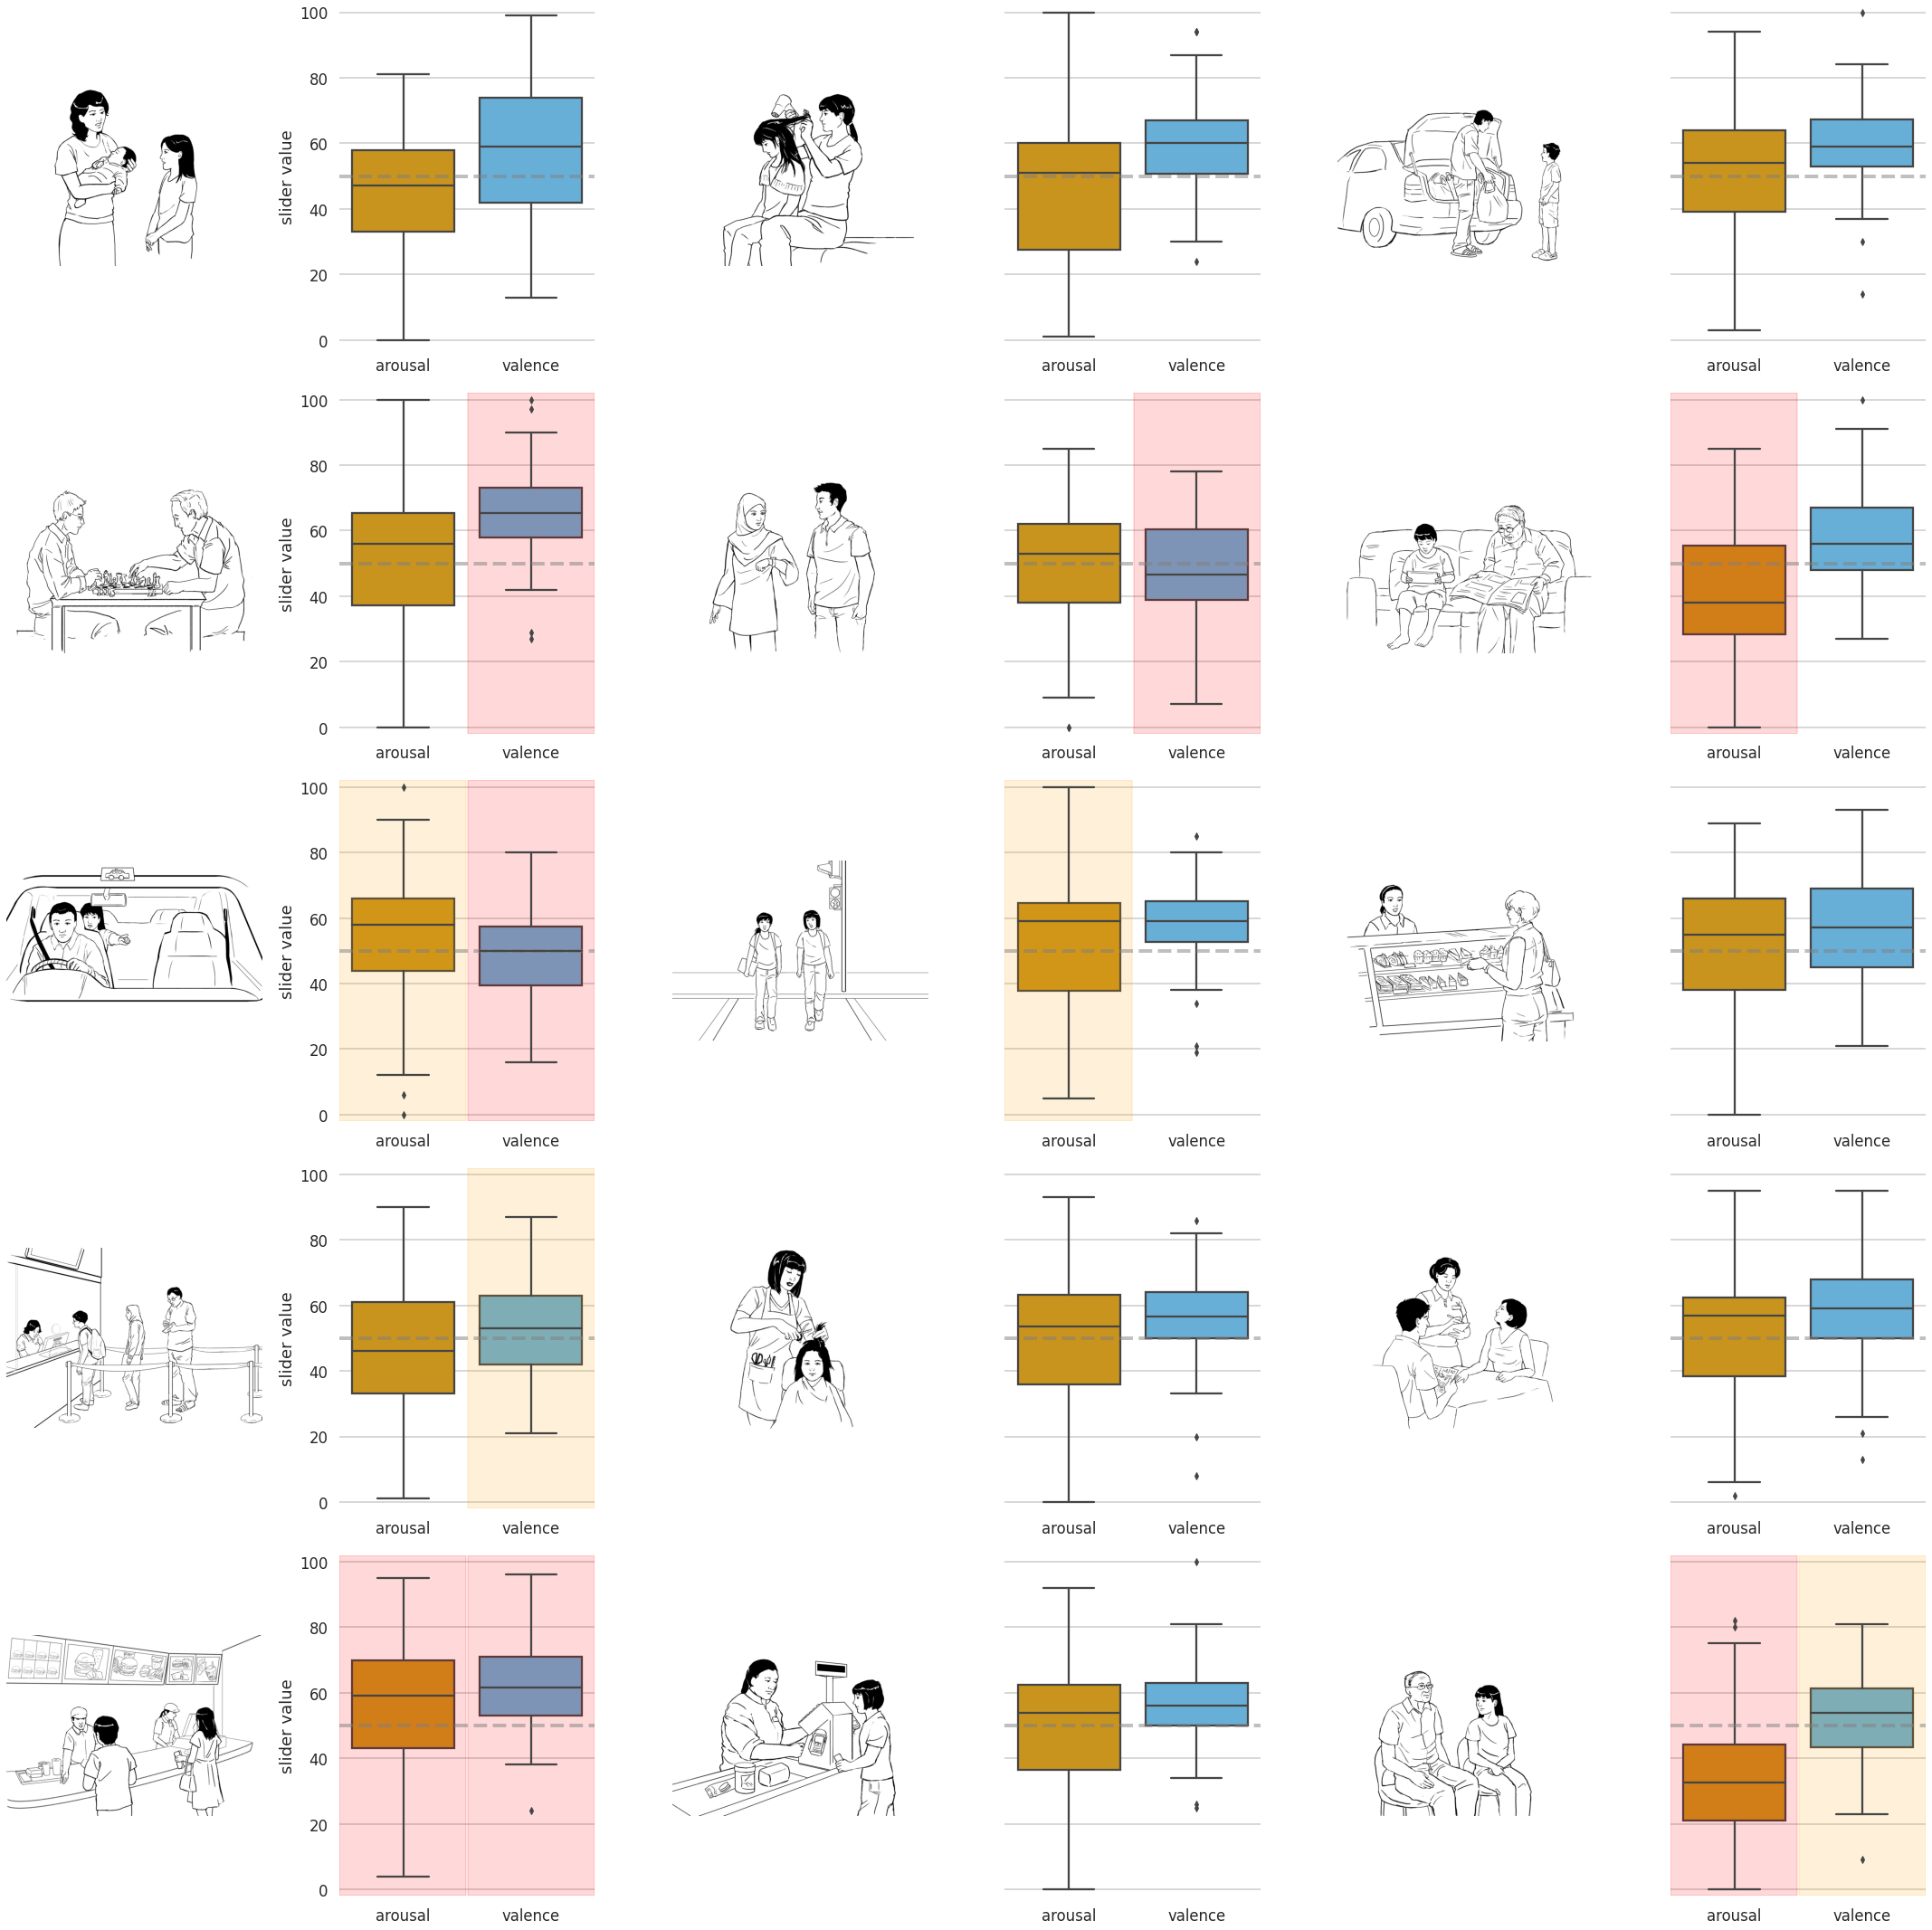

In [26]:

n_cols = 6
DB = "PiSCES"
fig, axs = plt.subplots(nrows=math.ceil(30 / n_cols), ncols=n_cols, figsize=(30, 30))

set_share_axes(axs=axs[:, 1::2], sharey=True)

for i, pic_name in enumerate(sorted(df_session[df_session.DB == DB].pic_name.unique())):
    ix2 = i * 2

    with open(
        list(speech_web_app_image_dir.joinpath(DB).glob(f"{pic_name}*"))[0], "rb"
    ) as f:
        img = plt.imread(f)

    if len(img.shape) == 2:
        img = np.repeat(img, 3).reshape(img.shape + (3,))

    axs[ix2 // n_cols, ix2 % n_cols].imshow(img)
    axs[ix2 // n_cols, ix2 % n_cols].axis("off")

    arousal_p = df[
        (df.pic_name == pic_name) & (df.variable == "arousal")
    ].p_value.values[0]
    valence_p = df[
        (df.pic_name == pic_name) & (df.variable == "valence")
    ].p_value.values[0]

    if arousal_p < 0.001:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(
            -0.5, 0.493, color="red", alpha=0.15
        )
    elif arousal_p < 0.05:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(
            -0.5, 0.493, color="orange", alpha=0.15
        )

    if valence_p < 0.001:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(
            0.507, 1.5, color="red", alpha=0.15
        )
    elif valence_p < 0.05:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(
            0.507, 1.5, color="orange", alpha=0.15
        )

    sns.boxplot(
        ax=axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols],
        data=df_session[(df_session.DB == DB) & (df_session.pic_name == pic_name)].melt(
            id_vars=set(df_session.columns).difference({"arousal", "valence"}),
            value_vars=["arousal", "valence"],
            var_name="slider_type",
            value_name="slider value",
        ),
        x="slider_type",
        y="slider value",
        palette=color_palette,
        # sharey=False,
        # bw=0.3,
        # inner="quartile",
    )

for ax in axs[:, 1::2].flat:
    ax.axhline(50, ls="--", lw=4, alpha=0.5, color="grey")
    ax.spines.bottom.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.set_xlabel("")
    ax.set_ylim(-2, 102)

for ax in axs[:, 3::2].flat:
    ax.set_ylabel("")

plt.tight_layout()


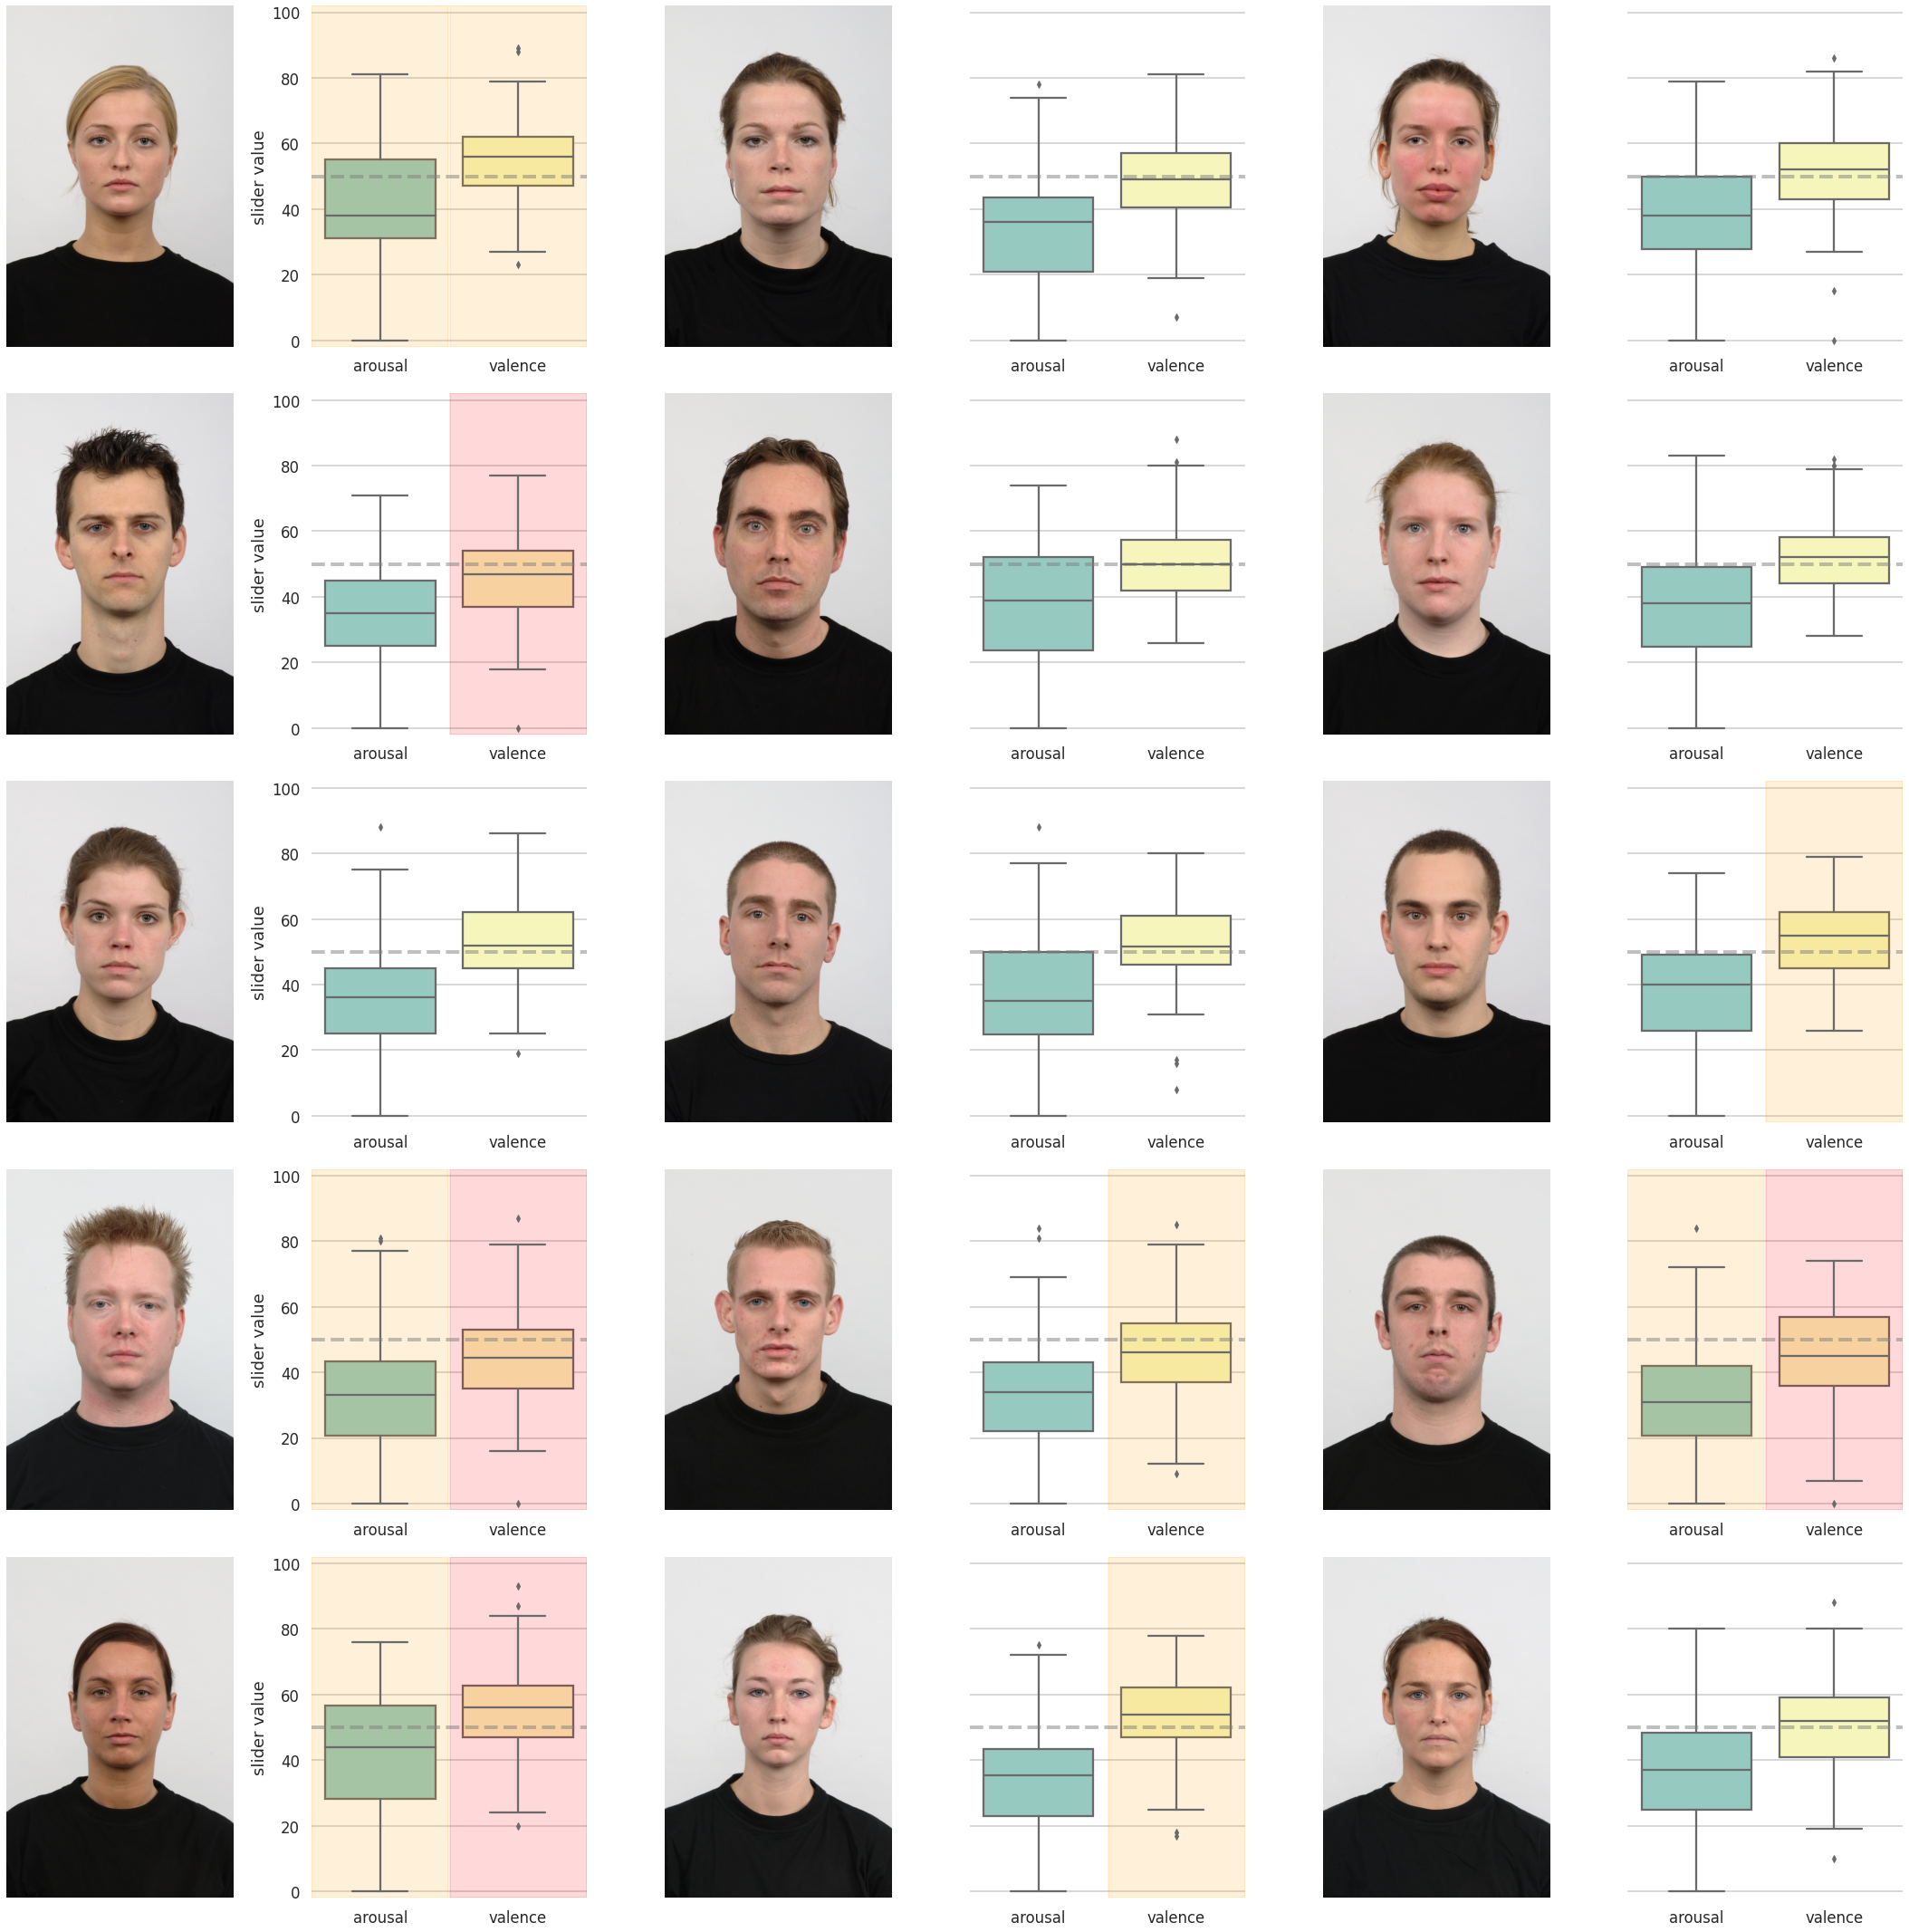

In [ ]:
n_cols = 6
DB = "Radboud"
fig, axs = plt.subplots(nrows=math.ceil(30 / n_cols), ncols=n_cols, figsize=(30, 30))

set_share_axes(axs=axs[:, 1::2], sharey=True)

for i, pic_name in enumerate(sorted(df_session[df_session.DB == DB].pic_name.unique())):
    ix2 = i * 2

    with open(
        list(speech_web_app_image_dir.joinpath(DB).glob(f"{pic_name}*"))[0], "rb"
    ) as f:
        img = plt.imread(f)

    axs[ix2 // n_cols, ix2 % n_cols].imshow(img)
    axs[ix2 // n_cols, ix2 % n_cols].axis("off")

    arousal_p = df[
        (df.pic_name == pic_name) & (df.variable == "arousal")
    ].p_value.values[0]
    valence_p = df[
        (df.pic_name == pic_name) & (df.variable == "valence")
    ].p_value.values[0]

    if arousal_p < 0.001:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(
            -0.5, 0.493, color="red", alpha=0.15
        )
    elif arousal_p < 0.05:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(
            -0.5, 0.493, color="orange", alpha=0.15
        )

    if valence_p < 0.001:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(
            0.507, 1.5, color="red", alpha=0.15
        )
    elif valence_p < 0.05:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(
            0.507, 1.5, color="orange", alpha=0.15
        )

    sns.boxplot(
        ax=axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols],
        data=df_session[(df_session.DB == DB) & (df_session.pic_name == pic_name)].melt(
            id_vars=set(df_session.columns).difference({"arousal", "valence"}),
            value_vars=["arousal", "valence"],
            var_name="slider_type",
            value_name="slider value",
        ),
        x="slider_type",
        y="slider value",
        palette="Set3",
        # bw=0.2,
        # inner="quartile",
    )

for ax in axs[:, 1::2].flat:
    ax.axhline(50, ls="--", lw=4, alpha=0.5, color="grey")
    ax.spines.bottom.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.set_xlabel("")
    ax.set_ylim(-2, 102)

# Only set a y-label for the first arousal-valence subplot column
for ax in axs[:, 3::2].flat:
    ax.set_ylabel("")


plt.tight_layout()


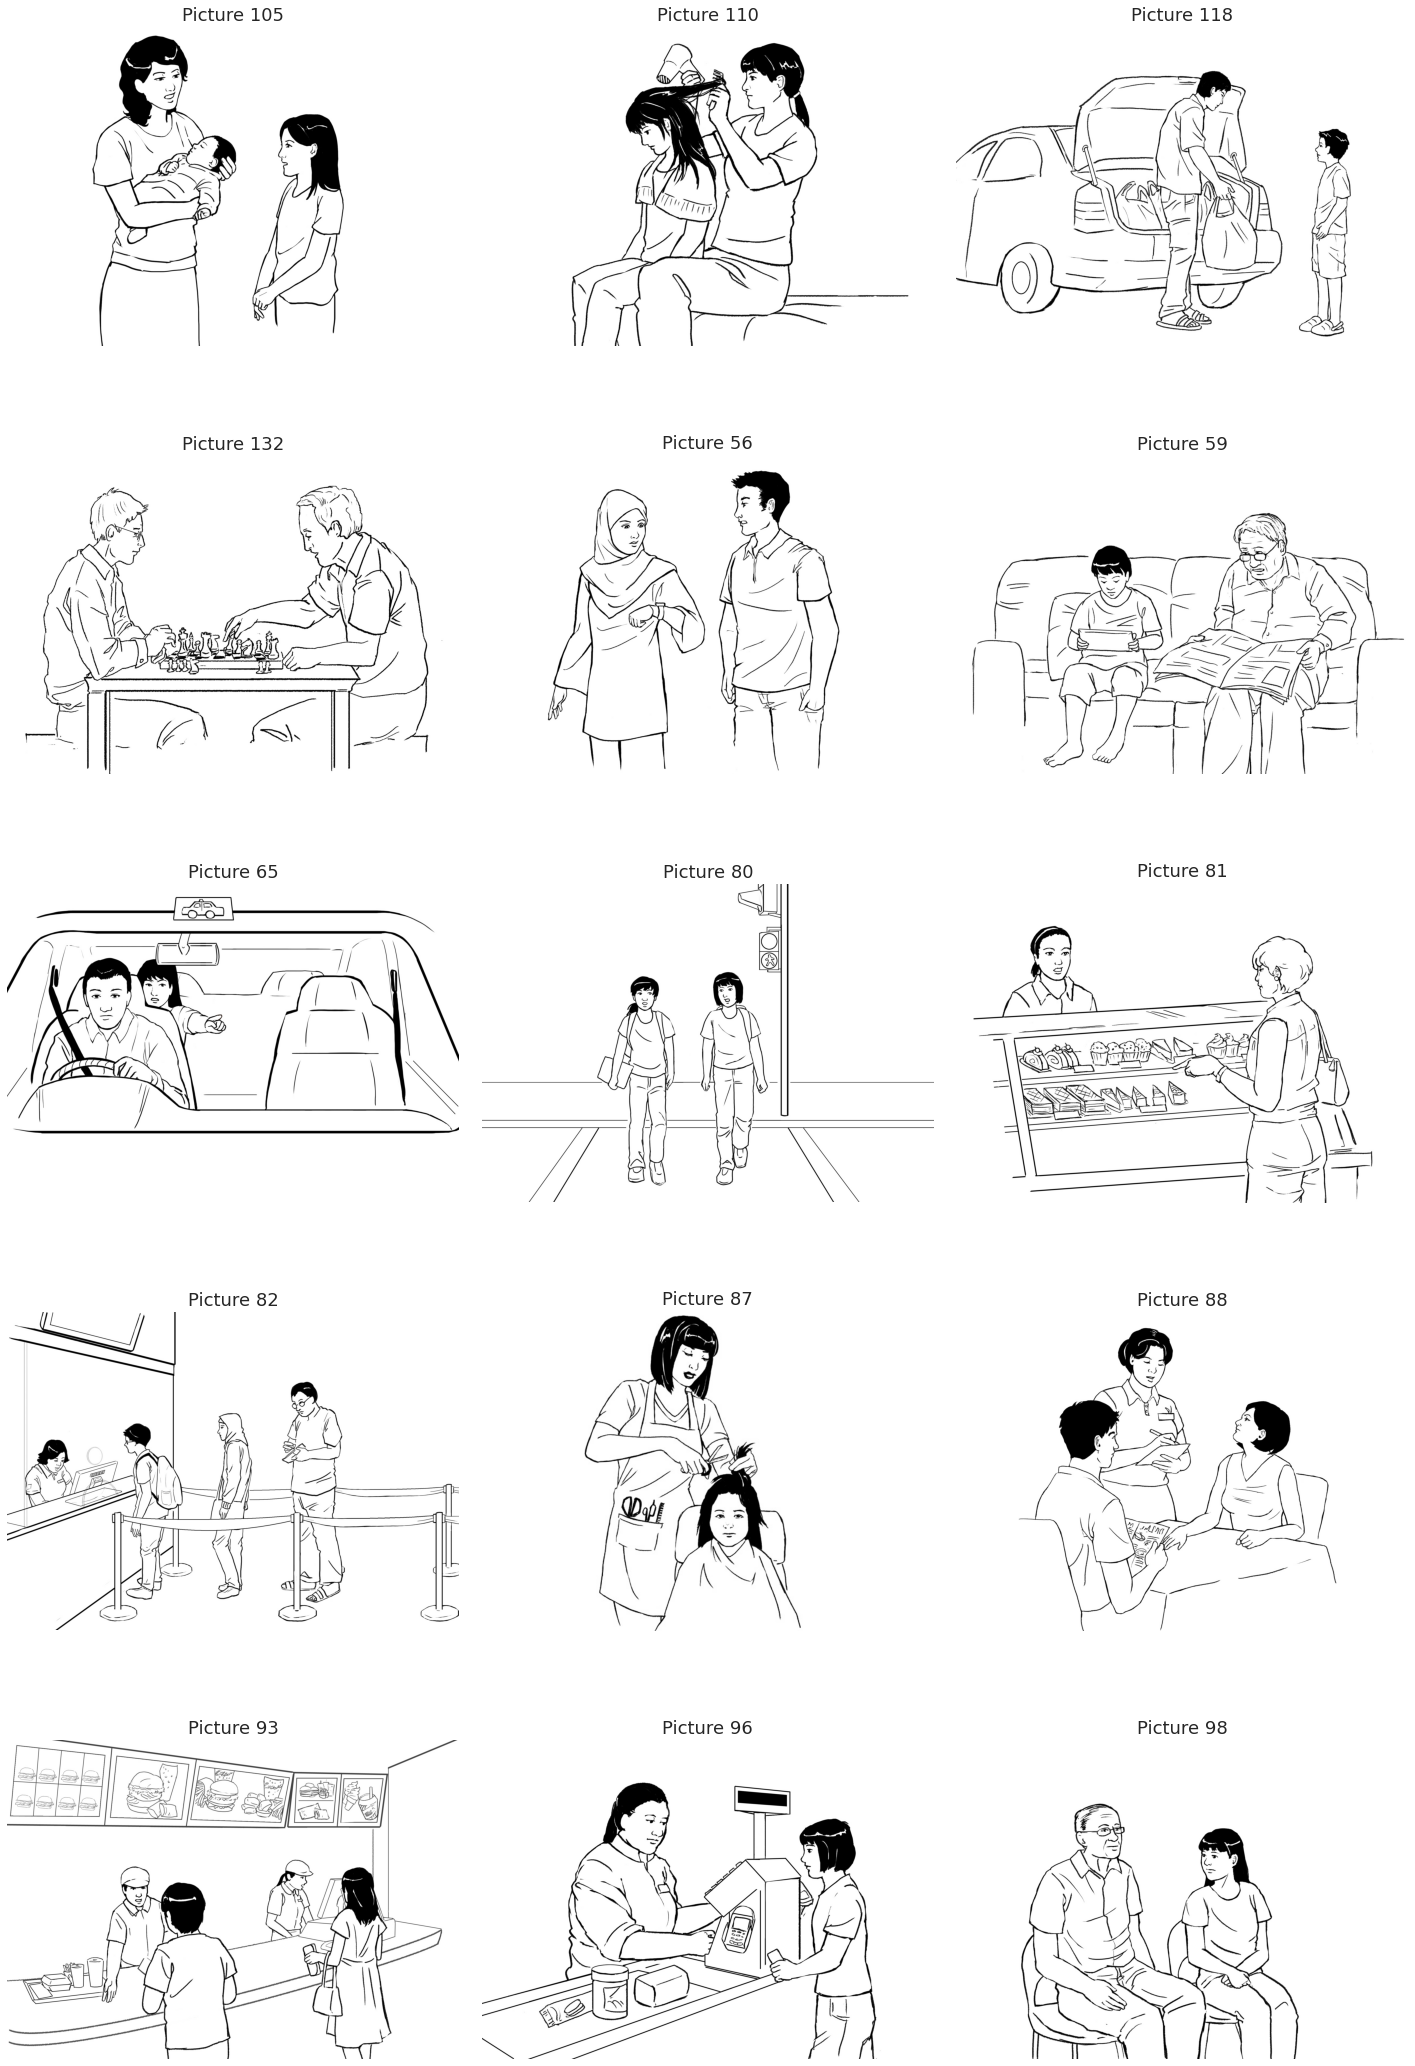

In [18]:
n_cols = 3
DB = "PiSCES"
show_distribution = False
n = 15
fig, axs = plt.subplots(nrows=math.ceil(n / n_cols), ncols=n_cols, figsize=(20, 30))


for i, pic_name in enumerate(sorted(df_session[df_session.DB == DB].pic_name.unique())):
    ix2 = i
    with open(
        list(speech_web_app_image_dir.joinpath(DB).glob(f"{pic_name}*"))[0], "rb"
    ) as f:
        img = plt.imread(f)

    if len(img.shape) == 2:
        img = np.repeat(img, 3).reshape(img.shape + (3,))

    axs[ix2 // n_cols, ix2 % n_cols].imshow(img)
    axs[ix2 // n_cols, ix2 % n_cols].axis("off")
    axs[ix2 // n_cols, ix2 % n_cols].set_title(pic_name)

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

fig.savefig("../reports/pisces.png", dpi=100)


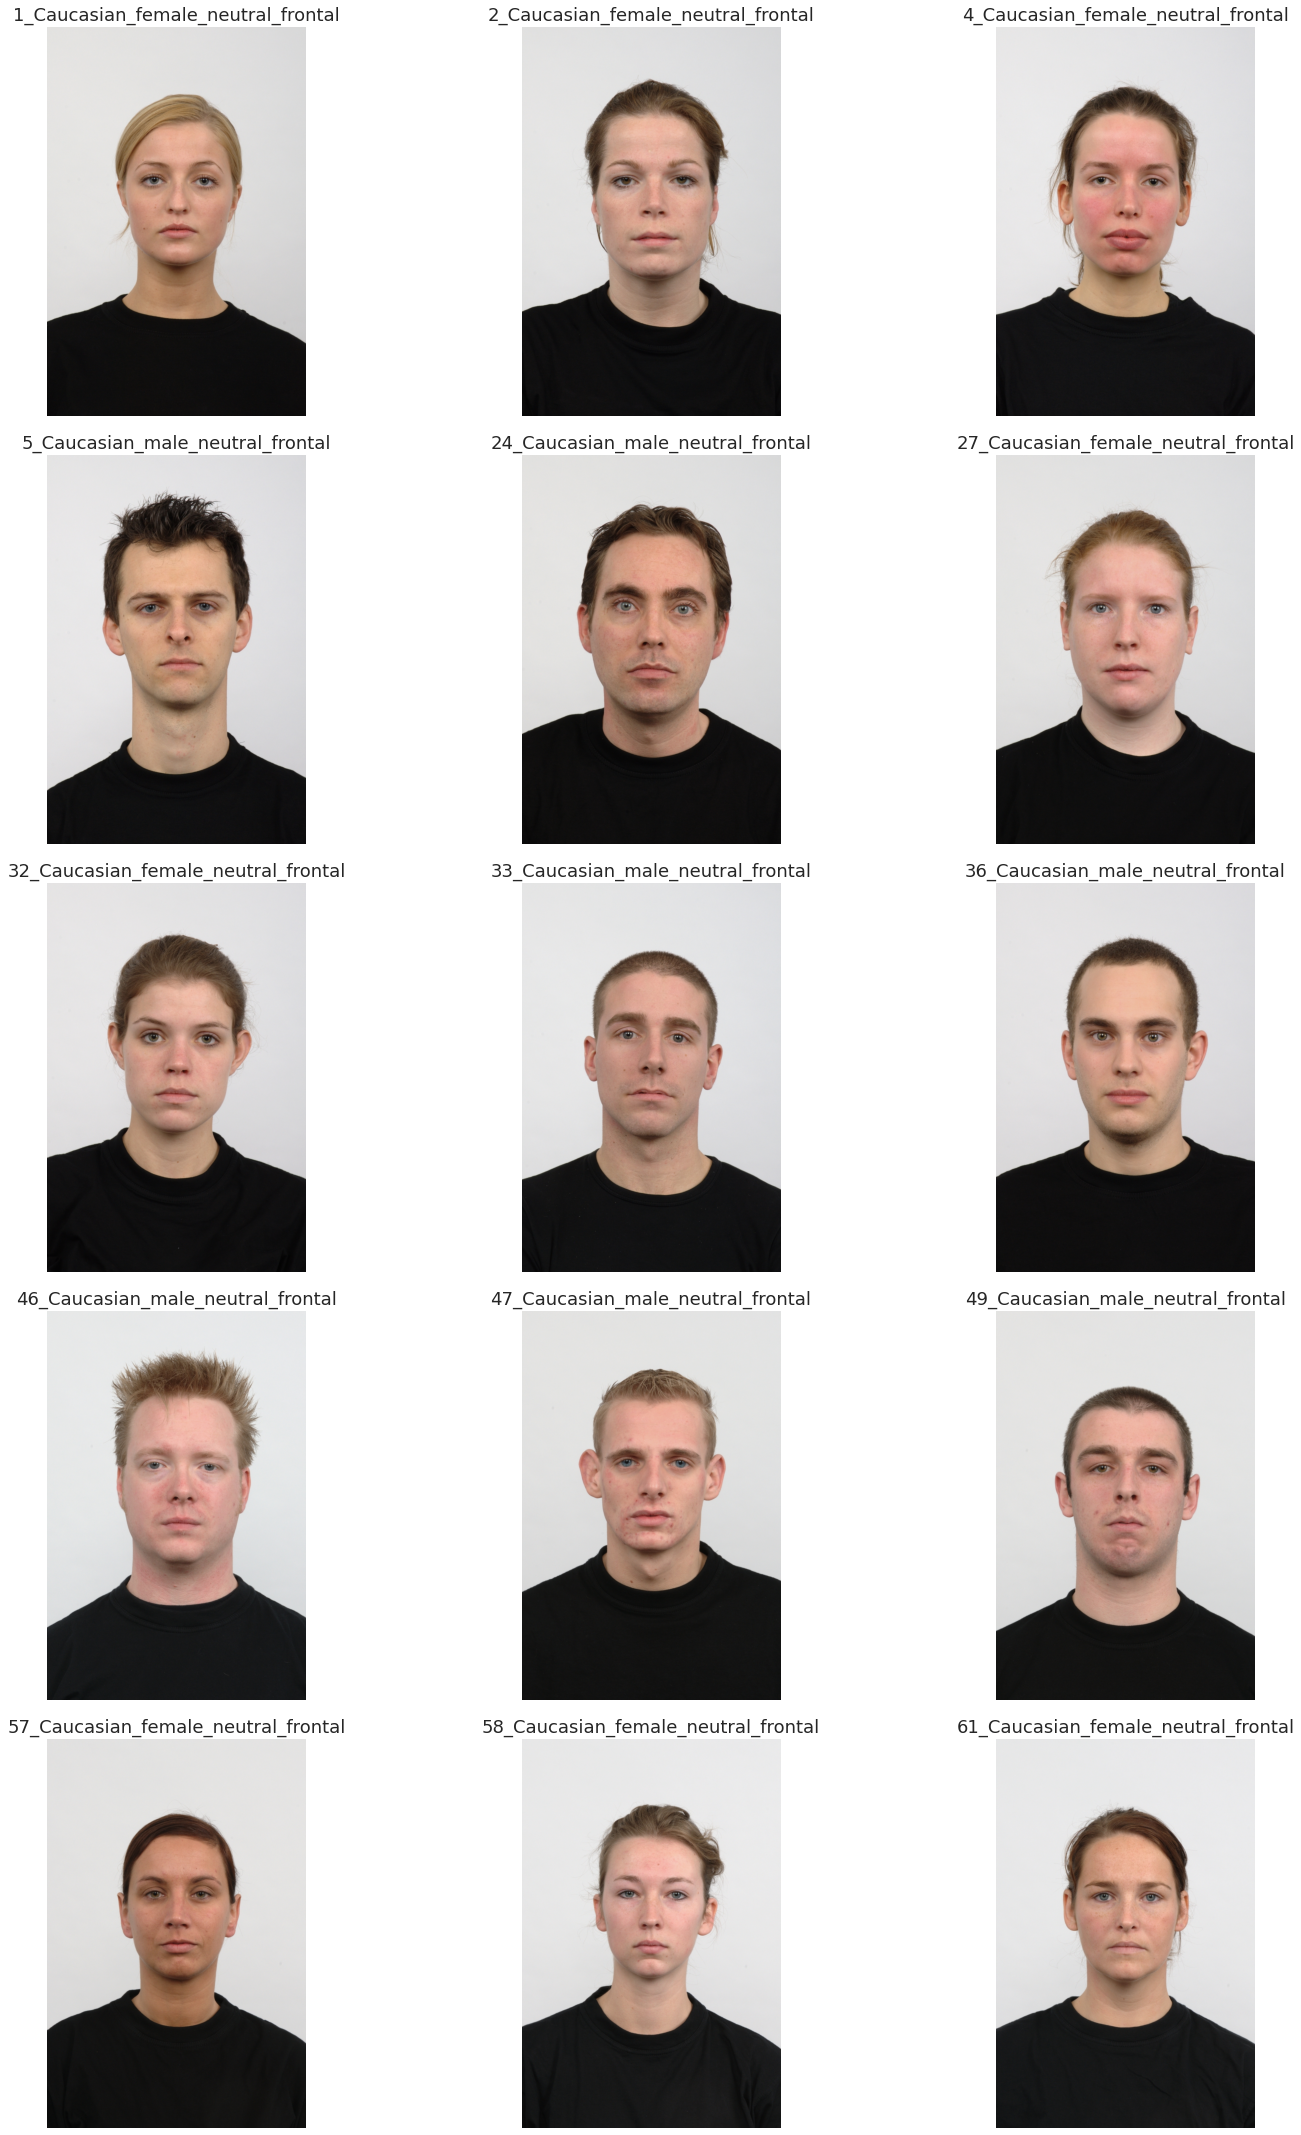

In [19]:
n_cols = 3
DB = "Radboud"
show_distribution = False
n = 15
fig, axs = plt.subplots(nrows=math.ceil(n / n_cols), ncols=n_cols, figsize=(20, 30))


for i, pic_name in enumerate(sorted(df_session[df_session.DB == DB].pic_name.unique())):
    ix2 = i
    with open(
        list(speech_web_app_image_dir.joinpath(DB).glob(f"{pic_name}*"))[0], "rb"
    ) as f:
        img = plt.imread(f)

    if len(img.shape) == 2:
        img = np.repeat(img, 3).reshape(img.shape + (3,))

    axs[ix2 // n_cols, ix2 % n_cols].imshow(img)
    axs[ix2 // n_cols, ix2 % n_cols].axis("off")
    axs[ix2 // n_cols, ix2 % n_cols].set_title(pic_name.lstrip('Rafd090_'))

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.show()


fig.savefig("../reports/radboud.png", dpi=100)

# Over time

In [6]:
radboud_index = (
    df_session[df_session.DB == "Radboud"].session_no.value_counts().iloc[:15].index
)
pisces_index = (
    df_session[df_session.DB == "PiSCES"].session_no.value_counts().iloc[:15].index
)
marloes_index = (
    df_session[df_session.DB == "Marloes"].session_no.value_counts().iloc[:7].index
)

valid_session_no_mask = (
    (df_session.session_no.isin(marloes_index) & (df_session.DB == "Marloes"))
    | (df_session.session_no.isin(radboud_index) & (df_session.DB == "Radboud"))
    | (df_session.session_no.isin(pisces_index) & (df_session.DB == "PiSCES"))
)
print(valid_session_no_mask.value_counts())
del marloes_index, pisces_index, radboud_index


True     3166
False      91
dtype: int64


In [21]:
# display(df_session[(df_session.session_no == 1) & (df_session.DB != "marloes")])
# display(df_session[(df_session.session_no == 2) & (df_session.DB != "PiSCES")])
# display(df_session[df_session.DB == "PiSCES"]["session_no"].unique())
# df_session[
#     (df_session.DB != "marloes")
#     & (df_session.ID != "36996711-b0d1-41f9-974d-65bf8f7746dc")
# ][["DB", "session_no"]].value_counts().sort_index(level=1).to_frame()[:35]
# # pisces starts with session_no 2, 4, 6, (MARLOES), 9, 11
# # radboud starts with session_no 3, 5, (MARLOES) 8, 10, 12


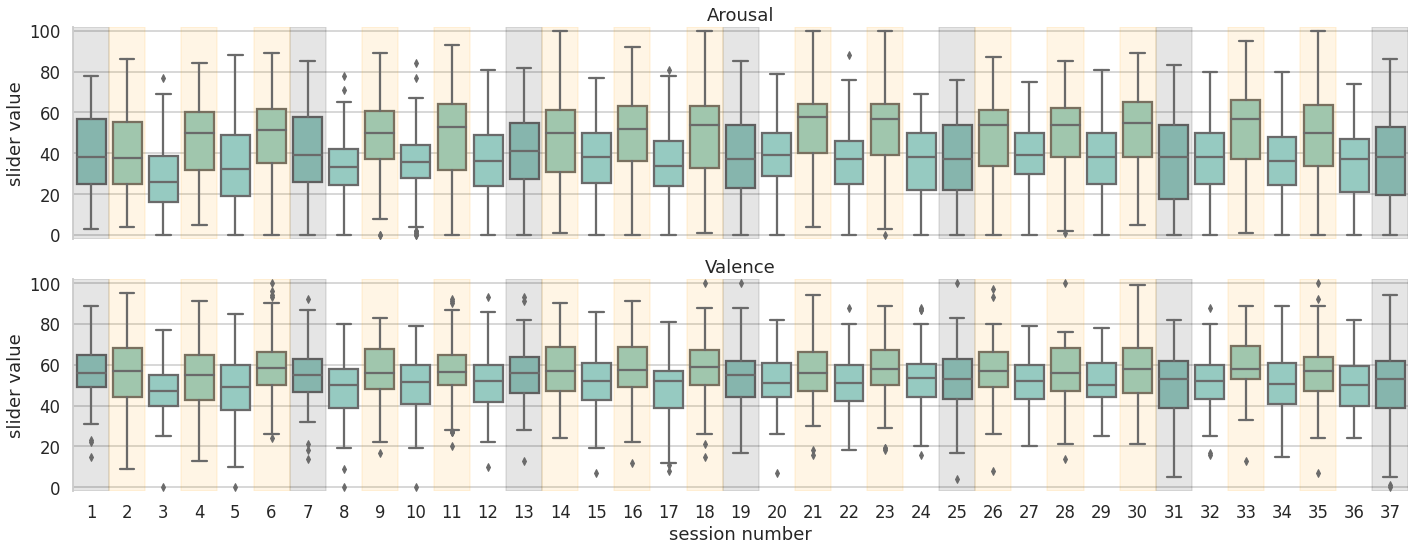

In [7]:
g = sns.catplot(
    data=df_session[valid_session_no_mask]
    .melt(
        id_vars=set(df_session.columns).difference({"arousal", "valence"}),
        value_vars=["arousal", "valence"],
        var_name="slider_type",
        value_name="slider value",
    )
    .rename(columns={"session_no": "session number"}),
    sharex=True,
    sharey=True,
    legend=True,
    kind="box",
    x="session number",
    y="slider value",
    row="slider_type",
    # hue="DB",
    # palette="Set3",
    color=(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    height=4,
    aspect=5,
    # s=3,
)


for ax in g.axes.flat:
    for marloes_id in [1, 7, 13, 19, 25, 31, 37]:
        ax.axvspan(marloes_id - 1.5, marloes_id - 0.5, alpha=0.1, color="black")
    for pisces_id in [2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26, 28, 30, 33, 35]:
        ax.axvspan(pisces_id - 1.5, pisces_id - 0.5, alpha=0.1, color="orange")
    ax.spines.bottom.set_visible(False)
    ax.set_ylim(-2, 102)
    ax.set_title(ax.get_title().split("=")[1].strip().capitalize())

# g.fig.suptitle(
#     "Orange=PiSCES  -  Grey=Marloes  -  No-color=RadBoud", y=1.0
# )


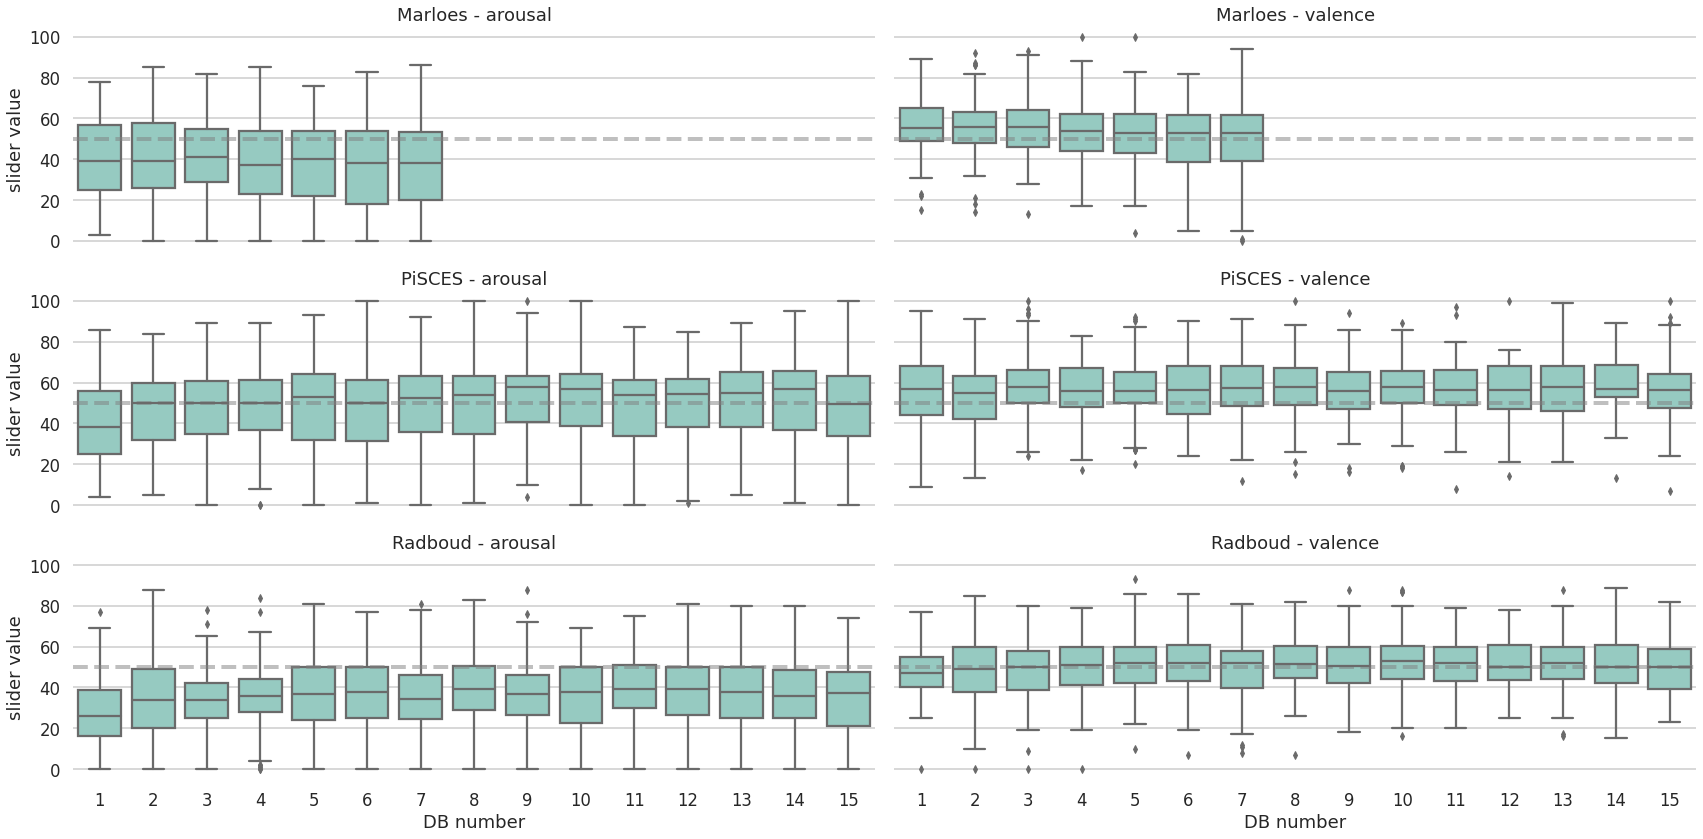

In [8]:
g = sns.catplot(
    data=df_session[df_session.DB_no < 16]
    .melt(
        id_vars=list(set(df_session.columns).difference({"arousal", "valence"})),
        value_vars=["arousal", "valence"],
        var_name="slider_type",
        value_name="slider value",
    )
    .rename(columns={"DB_no": "DB number"}),
    sharex=True,
    sharey=True,
    legend=True,
    kind="box",
    # kind='violin',
    # bw=0.2,
    x="DB number",
    y="slider value",
    row="DB",
    col="slider_type",
    color=(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    height=4,
    aspect=3,
)
g.set_titles("{row_name} - {col_name}")

for ax in g.axes.flat:
    ax.set_ylim(-5, 105)
    ax.axhline(50, ls="--", alpha=0.5, lw=4, color="grey")
    ax.spines.bottom.set_visible(False)
    ax.spines.left.set_visible(False)
